In [4]:
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from pettingzoo import AECEnv
from pettingzoo.utils import wrappers
from pettingzoo.utils.agent_selector import agent_selector

Initial state:


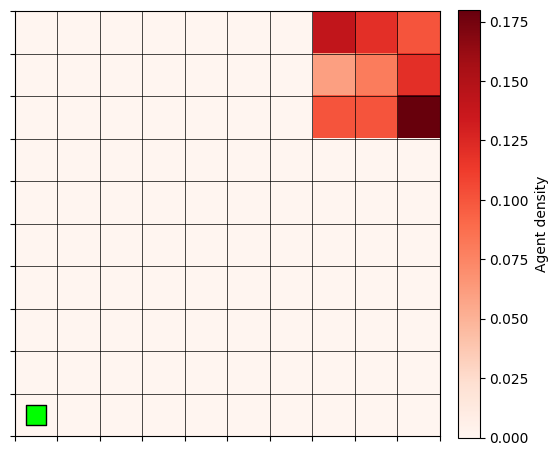

Step 1:


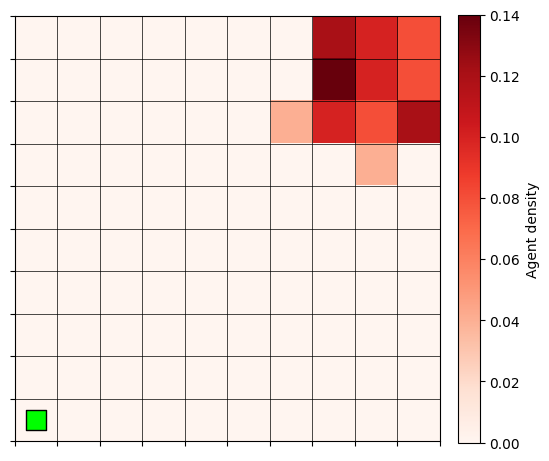

Step 2:


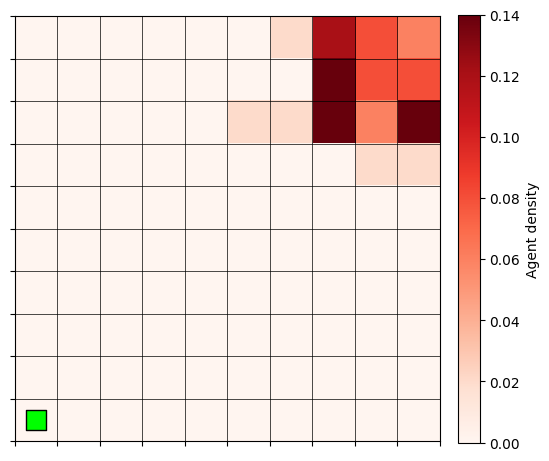

Step 3:


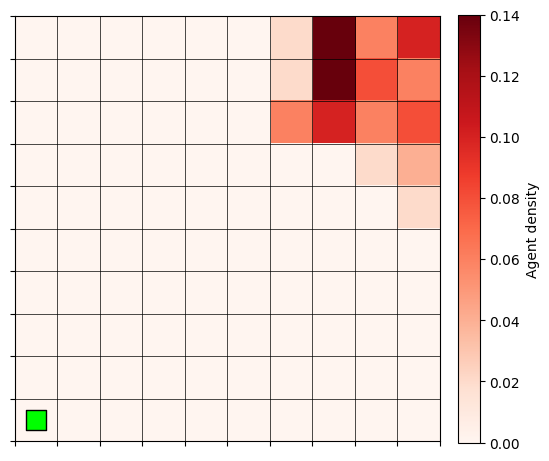

In [9]:
GRID_SIZE = 10

class GridWorldAECEnv(AECEnv):
    """Custom GridWorld environment following PettingZoo AEC interface with two agents"""
    metadata = {'render.modes': ['human'], "name": "gridworld_aec_v0"}

    def __init__(self, size=(GRID_SIZE, GRID_SIZE), target=(0, 0), obstacles=None, num_moving_agents=50):
        super().__init__()
        self.size = size
        self.target = target
        self.obstacles = obstacles if obstacles else []
        self.num_moving_agents = num_moving_agents

        # Define agents - one for each moving agent plus the traffic light agent
        self.agents = [f"movement_agent_{i}" for i in range(num_moving_agents)]
        self.agents.append("traffic_light_agent")
        self.possible_agents = self.agents[:]

        # Define action spaces
        # Traffic light agent: set traffic light intensity (0 to 1) for each grid cell
        self.action_spaces = {
            "traffic_light_agent": spaces.Box(low=0, high=1, shape=size, dtype=np.float32)
        }

        # Each movement agent has discrete action space
        for i in range(num_moving_agents):
            self.action_spaces[f"movement_agent_{i}"] = spaces.Discrete(5)  # 5 possible movements

        # Define observation spaces for both agents as arrays
        # Traffic light agent observation space: flattened traffic lights and mean field
        grid_area = size[0] * size[1]
        traffic_light_obs_size = grid_area * 2
        self.observation_spaces = {
            "traffic_light_agent": spaces.Box(low=0, high=1, shape=(traffic_light_obs_size,), dtype=np.float32)
        }

        # Each movement agent has its own observation space
        # position + flattened mean field + flattened traffic lights
        movement_obs_size = 2 + grid_area + grid_area
        for i in range(num_moving_agents):
            self.observation_spaces[f"movement_agent_{i}"] = spaces.Box(low=0, high=1, shape=(movement_obs_size,), dtype=np.float32)

        # Movement actions for the moving agents
        self.actions = [(-1, 0), (1, 0), (0, 0), (0, 1), (0, -1)]  # Left, Right, Stay, Up, Down

        # Initialize state variables
        self.positions = []  # Positions of all moving agents
        self.traffic_lights = np.zeros(size, dtype=np.float32)  # Traffic light intensity for each grid cell (0 to 1)
        self.steps = 0
        self.max_steps = 100
        self.mean_field = np.zeros(self.size, dtype=np.float32)

    def reset(self, seed=42, options=None):
        """Reset the environment to initial state"""
        random.seed(seed)

        # Initialize agents
        self.agents = self.possible_agents[:]
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

        # Initialize traffic lights (all at 0 intensity)
        self.traffic_lights = np.zeros(self.size, dtype=np.float32)

        # Initialize moving agents at random positions (top-left concentrated)
        self.positions = []
        for _ in range(self.num_moving_agents):
            x = int(9 - random.randint(0, 2))
            y = int(9 - random.randint(0, 2))
            self.positions.append((x, y))

        self.congestion_coefficient = 1
        self.steps = 0
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

        # Calculate initial mean field
        self._update_mean_field()

    def _update_mean_field(self):
        """Update the mean field representation"""
        mean_field = np.zeros(self.size, dtype=np.float32)
        for x, y in self.positions:
            mean_field[x, y] += 1
        self.mean_field = mean_field / max(self.num_moving_agents, 1)

    def is_valid_position(self, pos):
        """Check if a position is within bounds and not an obstacle."""
        x, y = pos
        return (0 <= x < self.size[0] and
                0 <= y < self.size[1] and
                pos not in self.obstacles)

    def _get_movement_probability(self, pos):
        """
        Calculate the probability of successful movement to a position
        based on traffic light intensity. Higher intensity means lower probability.
        """
        x, y = pos
        traffic_intensity = self.traffic_lights[x, y]
        # Probability decreases as traffic light intensity increases
        return 1.0 - traffic_intensity

    def step(self, action):
        """Execute one time step for the current agent"""
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection

        if agent == "traffic_light_agent":
            # Set traffic light intensities based on action (clamped to [0, 1])
            self.traffic_lights = np.clip(action.reshape(self.size), 0, 1).astype(np.float32)

            # Traffic light agent gets reward based on congestion management
            # Higher reward for placing traffic lights where there's high congestion
            congestion_management = - np.sum(self.mean_field * self.traffic_lights)

            self.rewards[agent] = congestion_management

        else:  # movement agent
            # Get the agent index from the agent name
            agent_idx = int(agent.split("_")[2])
            pos = self.positions[agent_idx]

            if pos == self.target:
                # Already at target, no movement needed
                self.rewards[agent] = 0
            else:
                # Get action vector
                action_vec = self.actions[action]
                new_pos = (pos[0] + action_vec[0], pos[1] + action_vec[1])

                # Check if new position is valid
                if self.is_valid_position(new_pos):
                    # Determine if movement succeeds based on traffic light intensity
                    movement_prob = self._get_movement_probability(new_pos)
                    if random.random() < movement_prob:
                        self.positions[agent_idx] = new_pos

                # Calculate reward
                time_cost = 1

                # Calculate congestion cost at the target cell
                if (0 <= new_pos[0] < self.size[0] and 0 <= new_pos[1] < self.size[1]):
                    congestion_cost = self.mean_field[new_pos[0], new_pos[1]]
                else:
                    congestion_cost = 10  # High penalty for invalid moves

                # Bonus for reaching the target
                target_bonus = 15 if new_pos == self.target else 0

                self.rewards[agent] = target_bonus - (time_cost + self.congestion_coefficient * congestion_cost)

            # Update mean field after all movement agents have acted
            if agent == self.agents[-2]:  # Second to last agent (last movement agent)
                self._update_mean_field()

                # Check termination conditions for the environment
                num_at_target = sum(1 for pos in self.positions if pos == self.target)
                terminated = num_at_target == self.num_moving_agents
                truncated = self.steps >= self.max_steps

                if terminated or truncated:
                    self.terminations = {a: True for a in self.agents}
                    self.truncations = {a: truncated for a in self.agents}

        # Update cumulative rewards
        self._cumulative_rewards[agent] += self.rewards[agent]

        # Move to next agent
        self.agent_selection = self._agent_selector.next()

        # Add to steps if all agents have acted
        if self.agent_selection == self.agents[0]:
            self.steps += 1

        # Clear rewards for the next step
        self.rewards = {a: 0 for a in self.agents}

    def observe(self, agent):
        """Return observation for a specific agent as a single array"""
        if agent == "traffic_light_agent":
            # Flatten both grid representations and concatenate them
            flat_mean_field = self.mean_field.copy().flatten()
            return np.concatenate([flat_mean_field])
        else:  # movement agent
            # Get the agent index from the agent name
            agent_idx = int(agent.split("_")[2])

            # Get the agent's position
            position = np.array(self.positions[agent_idx], dtype=np.float32)
            position[0] /= self.size[0]
            position[1] /= self.size[1]

            # Flatten the mean field and traffic lights arrays
            flat_mean_field = self.mean_field.copy().flatten()

            # Concatenate position, flattened mean field, and flattened traffic lights
            return np.concatenate([position, flat_mean_field])

    def render(self, mode="human"):
        """Render environment as a heatmap of agent density (mean-field)."""
        grid_size = self.size[0]

        # Create a new figure if none exists (e.g. after close())
        if not hasattr(self, "fig") or self.fig is None:
            plt.ion()  # enable interactive mode
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            self.im = None
            self.colorbar = None

        self.ax.clear()

        density = self.mean_field.copy()

        # Mask obstacles
        masked_density = np.ma.array(density, mask=False)
        for ox, oy in self.obstacles:
            masked_density[ox, oy] = np.nan

        cmap = plt.cm.Reds
        cmap.set_bad(color="black")

        im = self.ax.imshow(
            masked_density,
            origin="upper",
            cmap=cmap,
            interpolation="nearest",
        )

        # Mark target
        self.ax.scatter(
            self.target[1],
            self.target[0],
            marker="s",
            c="lime",
            edgecolor="black",
            s=200,
            label="Target"
        )

        self.ax.set_xticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_yticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True, which="both", color="black", linewidth=0.5)

        self.ax.set_xlim(-0.5, grid_size - 0.5)
        self.ax.set_ylim(-0.5, grid_size - 0.5)

        if self.colorbar is None:
            self.colorbar = self.fig.colorbar(im, ax=self.ax, fraction=0.046, pad=0.04, label="Agent density")
        else:
            self.colorbar.update_normal(im)

        plt.pause(0.01)  # redraw non-blocking


    def close(self):
        """Close the environment and release the figure."""
        if hasattr(self, "fig") and self.fig is not None:
            plt.close(self.fig)
            self.fig = None
            self.ax = None
            self.im = None
            self.colorbar = None


# Example usage and test
if __name__ == "__main__":
    env = GridWorldAECEnv(num_moving_agents=50)
    env.reset()

    print("Initial state:")
    env.render()
    env.close()

    # Test a few steps
    for step in range(3):
        print(f"Step {step + 1}:")

        # Process each agent's turn
        for agent in env.agents:
            env.agent_selection = agent

            if agent == "traffic_light_agent":
                # Create a random traffic light pattern
                traffic_action = np.random.rand(GRID_SIZE, GRID_SIZE)
                env.step(traffic_action)
            else:
                # Move randomly for movement agents
                move_action = random.randint(0, 4)
                env.step(move_action)

        env.render()
        env.close()